In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xarray.ufuncs import cos, deg2rad, log
import climlab
from metpy.plots import SkewT

In [2]:
# This will try to read the data over the internet.
temperature_filename = 'air.mon.1981-2010.ltm.nc'
humidity_filename = 'shum.mon.1981-2010.ltm.nc'
#  to read over internet
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
path = ncep_url
#  Open handle to data
ncep_air = xr.open_dataset(path + temperature_filename, decode_times=False)
ncep_shum = xr.open_dataset(path + humidity_filename, decode_times=False)

In [3]:
#  Take global, annual average and convert to Kelvin
weight = cos(deg2rad(ncep_air.lat)) / cos(deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time')) 
shum_global = (ncep_shum.shum * weight).mean(dim=('lat','lon','time'))

In [4]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
atm_control = xr.open_dataset( datapath + 'som_1850_f19/som_1850_f19.cam.h0.clim.nc' + endstr, decode_times=False)

In [5]:
Qglobal = ((atm_control.Q * atm_control.gw)/atm_control.gw.mean(dim='lat')).mean(dim=('lat','lon','time'))

In [6]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

In [7]:
#  Define two types of cloud, high and low
cldfrac = np.zeros_like(state.Tatm)
r_liq = np.zeros_like(state.Tatm)
r_ice = np.zeros_like(state.Tatm)
clwp = np.zeros_like(state.Tatm)
ciwp = np.zeros_like(state.Tatm)
#   indices
high = 13  # corresponds to 227 hPa
low = 21   #  corresponds to 788 hPa
#  A high, thin ice layer (cirrus cloud)
r_ice[high] = 14. # Cloud ice crystal effective radius (microns)
ciwp[high] = 10.  # in-cloud ice water path (g/m2)
cldfrac[high] = 0.322
#  A low, thick, water cloud layer (stratus)
r_liq[low] = 14.  # Cloud water drop effective radius (microns)
clwp[low] = 100.  # in-cloud liquid water path (g/m2)
cldfrac[low] = 0.21
# wrap everything up in a dictionary
mycloud = {'cldfrac': cldfrac,
          'ciwp': ciwp,
          'clwp': clwp,
          'r_ice': r_ice,
          'r_liq': r_liq}

In [38]:
rad = climlab.radiation.RRTMG(name='all gases',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              #albedo = 0.125,
                              albedo = 0.25,  # tuned to give reasonable ASR for reference cloud-free model
                              #**mycloud,
                             )

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


In [39]:
rad_noO3 = climlab.process_like(rad)
rad_noO3.absorber_vmr['O3'] *= 0.
rad_noO3.name = 'no O3'

rad_noH2O = climlab.process_like(rad)
rad_noH2O.specific_humidity *= 0.
rad_noH2O.name = 'no H2O'

rad_noO3_noH2O = climlab.process_like(rad_noO3)
rad_noO3_noH2O.specific_humidity *= 0.
rad_noO3_noH2O.name = 'no O3, no H2O'

In [40]:
rad_models = [rad, rad_noO3, rad_noH2O, rad_noO3_noH2O]

In [41]:
rc_models = []
for r in rad_models:
    newrad = climlab.process_like(r)
    conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                               state=newrad.state,
                                               adj_lapse_rate=6.5,
                                               timestep=newrad.timestep,)
    rc = newrad + conv
    rc.name = newrad.name
    rc_models.append(rc)

In [42]:
for model in rad_models + rc_models:
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
        model.step_forward()

In [43]:
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-80, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

In [44]:
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

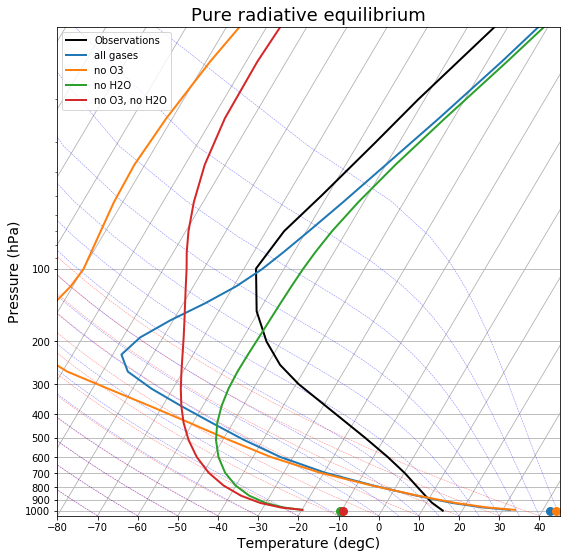

In [45]:
skew = make_skewT()
for model in rad_models:
    add_profile(skew, model)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

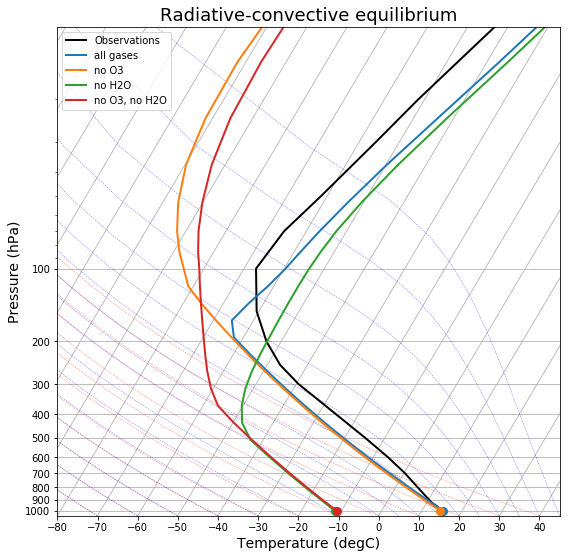

In [46]:
skew = make_skewT()
for model in rc_models:
    add_profile(skew, model)
skew.ax.set_title('Radiative-convective equilibrium', fontsize=18);

In [65]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
#  Initialize a nearly dry column (small background stratospheric humidity)
state['q'] = np.ones_like(state.Tatm) * 5.E-6
#  ASYNCHRONOUS COUPLING -- the radiation uses a much longer timestep
short_timestep = climlab.constants.seconds_per_hour
#  Radiation coupled to water vapor
rad = climlab.radiation.RRTMG(name='Radiation',
                    state=state,
                    specific_humidity=state.q,
                    albedo=0.2,
                    timestep=24*short_timestep)
#  Convection scheme -- water vapor is a state variable
conv = climlab.convection.EmanuelConvection(name='Convection',
                              state=state,
                              timestep=short_timestep,
                              ALPHA=0.1,)
#  Surface heat flux processes
shf = climlab.surface.SensibleHeatFlux(name='SHF',
                              state=state, Cd=0.5E-3, U=100.,
                              timestep=short_timestep)
lhf = climlab.surface.LatentHeatFlux(name='LHF',
                              state=state, Cd=0.5E-3, U=100.,
                              timestep=short_timestep)
#  Couple all the submodels together
turb = climlab.couple([shf,lhf], name='Turbulent')
model = climlab.couple([rad, conv, turb], name='RadiativeConvectiveModel')
print(model)

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
  q: (26,) 
The subprocess tree: 
RadiativeConvectiveModel: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convection: <class 'climlab.convection.emanuel_convection.EmanuelConvection'>
   Turbulent: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
      LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>



In [66]:
model.compute_diagnostics()
while np.abs(model.ASR-model.OLR) > 0.01:
    model.step_forward()

In [67]:
for n in range(1000):
    model.step_forward()

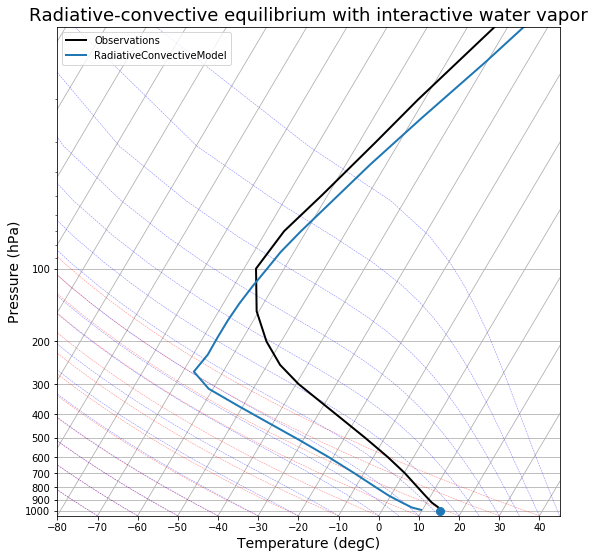

In [68]:
skew = make_skewT()
add_profile(skew, model)
skew.ax.set_title('Radiative-convective equilibrium with interactive water vapor', fontsize=18);

In [69]:
conv.IFLAG

array([1], dtype=int32)